# Training an image classifier
We will do the following steps in order:

Load and normalize the CIFAR10 training and test datasets using torchvision  
Define a Convolutional Neural Network  
Define a loss function  
Train the network on the training data  
Test the network on the test data  

训练流程如下：  

通过调用 torchvision 加载和归一化 CIFAR10 训练集和测试集；  
构建一个卷积神经网络；  
定义一个损失函数；  
在训练集上训练网络；  
在测试集上测试网络性能。  

## 1. Load and normalize CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [23]:
#import necessary package
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].  
torchvision 的数据集输出的图片都是 PILImage ，即取值范围是 [0, 1] ，这里需要做一个转换，变成取值范围是 [-1, 1] , 代码如下所示：

In [24]:
# 将图片数据从 [0,1] 归一化为 [-1, 1] 的取值范围
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.

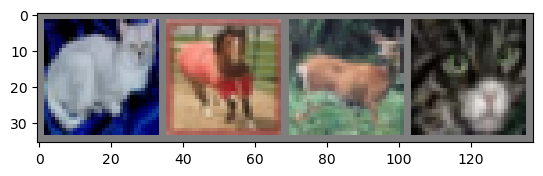

  cat horse  deer   cat


In [25]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image 展示图片的函数
def imshow(img):
    img = img / 2 + 0.5     # unnormalize 非归一化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images 随机获取训练集图片
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images 展示图片
imshow(torchvision.utils.make_grid(images))
# print labels 打印图片类别标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolutional Neural Network
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).  
这部分内容其实直接采用上一节定义的网络即可，除了修改 conv1 的输入通道，从 1 变为 3，因为这次接收的是 3 通道的彩色图片。

In [26]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.

这里采用类别交叉熵函数和带有动量的 SGD 优化方法：


In [27]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.

第四步自然就是开始训练网络，指定需要迭代的 epoch，然后输入数据，指定次数打印当前网络的信息，比如 loss 或者准确率等性能评价标准。

In [28]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels] 获取输入数据
        inputs, labels = data

        # zero the parameter gradients 清空梯度缓存
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics 打印统计信息
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            
print('Finished Training! Total cost time: ', time.time() - start)

[1,  2000] loss: 2.198
[1,  4000] loss: 1.816
[1,  6000] loss: 1.654
[1,  8000] loss: 1.562
[1, 10000] loss: 1.540
[1, 12000] loss: 1.448
[2,  2000] loss: 1.386
[2,  4000] loss: 1.358
[2,  6000] loss: 1.321
[2,  8000] loss: 1.333
[2, 10000] loss: 1.303
[2, 12000] loss: 1.309
Finished Training! Total cost time:  4510.420213937759


Let's quickly save our trained model:
See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

In [12]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

训练好一个网络模型后，就需要用测试集进行测试，检验网络模型的泛化能力。对于图像分类任务来说，一般就是用准确率作为评价标准。  

首先，我们先用一个 batch 的图片进行小小测试，这里 batch=4 ，也就是 4 张图片，代码如下：



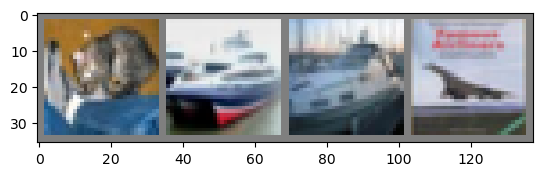

GroundTruth:  cat   ship  ship  plane


In [13]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model wasn't necessary here, we only did it to illustrate how to do so):
    
然后用这四张图片输入网络，看看网络的预测结果：

In [14]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:

接着，让我们看看在整个测试集上的准确率可以达到多少吧！

In [16]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

结果是 56% ，因为权重初始化问题，可能多少有些浮动，相比随机猜测 10 个类别的准确率(即 10%)，这个结果是不错的，当然实际上是非常不好，不过我们仅仅采用 5 层网络，而且仅仅作为教程的一个示例代码。

然后，还可以再进一步，查看每个类别的分类准确率，跟上述代码有所不同的是，计算准确率部分是 c = (predicted == labels).squeeze()，这段代码其实会根据预测和真实标签是否相等，输出 1 或者 0，表示真或者假，因此在计算当前类别正确预测数量时候直接相加，预测正确自然就是加 1，错误就是加 0，也就是没有变化。

In [17]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: plane is 60.0 %
Accuracy for class: car   is 74.5 %
Accuracy for class: bird  is 56.5 %
Accuracy for class: cat   is 35.1 %
Accuracy for class: deer  is 41.0 %
Accuracy for class: dog   is 42.4 %
Accuracy for class: frog  is 64.3 %
Accuracy for class: horse is 57.7 %
Accuracy for class: ship  is 68.7 %
Accuracy for class: truck is 60.7 %


# Train on GPU (M1 macbook)
For English based student,you can see details in "4.TrainYourNetwork_2_Official.ipynb" last part

深度学习自然需要 GPU 来加快训练速度的。所以接下来介绍如果是在 GPU 上训练，应该如何实现。

首先，需要检查是否有可用的 GPU 来训练，代码如下：

In [30]:
import torch
##这是基于cuda CPU的语句 device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device('mps')
print(device)

mps


输出结果如mps/cuda:0，这表明你的第一块 GPU 显卡或者唯一的 GPU 显卡是空闲可用状态，否则会打印 cpu 。

既然有可用的 GPU ，接下来就是在 GPU 上进行训练了，其中需要修改的代码如下，分别是需要将网络参数和数据都转移到 GPU 上：

In [31]:
net.to(device)
inputs, labels = inputs.to(device), labels.to(device)

修改后的训练代码：

In [32]:
import time
# 在 GPU 上训练注意需要将网络和数据放到 GPU 上
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

start = time.time()
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入数据
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # 清空梯度缓存
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 打印统计信息
        running_loss += loss.item()
        if i % 2000 == 1999:
            # 每 2000 次迭代打印一次信息
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training! Total cost time: ', time.time() - start)

[1,  2000] loss: 1.139
[1,  4000] loss: 1.147
[1,  6000] loss: 1.147
[1,  8000] loss: 1.131
[1, 10000] loss: 1.127
[1, 12000] loss: 1.123
[2,  2000] loss: 1.023
[2,  4000] loss: 1.045
[2,  6000] loss: 1.069
[2,  8000] loss: 1.061
[2, 10000] loss: 1.077
[2, 12000] loss: 1.065
Finished Training! Total cost time:  199.7595920562744
